For this notebook, you need to install : 
+ ODFTT from Mumott's package : https://gitlab.com/liebi-group/software/odf-mumott

# 4 - Reconstruction slice by slice

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import odftt.plot_tools
from tqdm import tqdm
import pickle
import h5py
import sys

from utils import *
from scipy.spatial.transform import Rotation as R

from odftt.io import load_series
from odftt.texture import grids, point_groups, odfs
from odftt.tomography_models import FromArrayModel
from odftt.crystallography import cubic
from odftt.optimization import FISTA
from mumott import Geometry 


INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


### Parameters of the experiment
+ **z_slice_index**: index of one slice to check the reconstruction parameters

In [2]:
z_slice_index = 0
sample = 'textom_posth14_post_beamdown'

with h5py.File(f'auxillary_files/{sample}_corrected_data.h5', 'r') as file:
    number_of_rotations, number_of_y_positions, number_of_slices, number_of_azim, n_hkl = file['data_array'].shape
    rot_angles = np.array(file['rotangle_degrees'])
    azim_angles = np.array(file['aziangle_degrees'])
    data_array = np.array(file['data_array'][:,:,z_slice_index:z_slice_index+1,:,:])
    hkl_list = np.array(file['hkl_list'])
    gap_mask = np.array(file['gap_mask'])
    coordinates = np.array(file['coordinates'])

# Reconstruction geometry
geometry = Geometry()
geometry.read('auxillary_files/2d.mumottgeometry')

# mask out detector gaps
weigth_array = np.ones(data_array.shape)
weigth_array[:,:,:,~gap_mask] = False


## Set up reconstruction model

+ **grid_resolution_parameter**: This parameter sets the angular resolution of the ODF-model,
+ **A, B, point_group**: define lattice parameters
+ **grid**: define the grid of orientations on which the texture will be reconstructed.

PS : it is tempting to increase the number of processes to compute this grid faster, however this error appears above 4 process : `Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.` <br />

In [3]:
grid_resolution_parameter = 15

# Define lattice
A, B = cubic()
point_group = point_groups.octahedral

grid = grids.hopf_grid(grid_resolution_parameter, point_group)
kernel_sigma = (np.pi**2 * 8 / len(point_group) / len(grid) )**(1/3) * 0.5
print(f'Resolution is about {2*kernel_sigma*180/np.pi:.1f}° with {len(grid)} orientation-grid points.')

Resolution is about 10.0° with 612 orientation-grid points.


In [4]:
odf = odfs.Brownian(grid, point_groups.octahedral, kernel_sigma)
h_vectors = [B @ hkl for hkl in hkl_list] #  The hkl_list needs to be in 3-index format,
                                          #  not the special hexagonal 4 index system.

# Procompute all the pole-figure matrices
basis_function_arrys = odf.compute_polefigure_matrices_parallel(coordinates, h_vectors, num_processes=8, print_progress=True) 
model = FromArrayModel(basis_function_arrys, geometry)




Starting parallel computation of polefiugres.

0% done. Time elapsed: 0:00:04.273943
1% done. Time elapsed: 0:00:04.274315
2% done. Time elapsed: 0:00:04.274341
3% done. Time elapsed: 0:00:04.274357
4% done. Time elapsed: 0:00:04.274379
5% done. Time elapsed: 0:00:07.006904
6% done. Time elapsed: 0:00:07.007150
7% done. Time elapsed: 0:00:07.352265
8% done. Time elapsed: 0:00:07.489722
9% done. Time elapsed: 0:00:09.750867
10% done. Time elapsed: 0:00:10.160233
11% done. Time elapsed: 0:00:10.423474
12% done. Time elapsed: 0:00:10.622243
13% done. Time elapsed: 0:00:10.823770
14% done. Time elapsed: 0:00:13.332758
15% done. Time elapsed: 0:00:13.709213
16% done. Time elapsed: 0:00:13.809334
17% done. Time elapsed: 0:00:14.010403
18% done. Time elapsed: 0:00:16.127761
19% done. Time elapsed: 0:00:16.776380
20% done. Time elapsed: 0:00:17.045465
21% done. Time elapsed: 0:00:17.146976
22% done. Time elapsed: 0:00:17.343165
23% done. Time elapsed: 0:00:19.761754
24% done. Time elapsed: 0:0

Optimize the results with the least square method. 
+ **optimizer**: Calculate an apropriate ste-size parameter for the gradient descent algorithm
+ **maxiter**: number of iterations. More iterations --> sharper texture, but too much iterations leads to overfitting.


In [6]:
optimizer = FISTA(model, data_array, weights = weigth_array, maxiter = 50)
x_RBF, convergence_curve = optimizer.optimize()

step_size_parameter = optimizer.step_size_parameter
print(step_size_parameter)

with h5py.File('auxillary_files/ODF_model_data.h5', 'w') as file:
    file.create_dataset('grid', data=odf.rotations.as_euler('zyz'))
    file.create_dataset('sigma', data=kernel_sigma)
    file.create_dataset('step_size_parameter', data=step_size_parameter)
    file.create_dataset('point_group', data=np.stack([r.as_euler('zyz') for r in point_group]))
    file.create_dataset('reciprocal_lattice_matrix', data=B)
    grp = file.create_group('pf_matrices')
    for rot_index, matrix in enumerate(basis_function_arrys):
        grp.create_dataset(f'rot_{rot_index}', data = matrix)

Estimating largest safe step size


Loss = 7.85E+15: 100%|██████████| 50/50 [03:20<00:00,  4.01s/it]
/home/esrf/ljegou/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3699: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  exec(code_obj, self.user_global_ns, self.user_ns)


1.5244088204412904e-11


Show the convergence curve and the texture coefficient for the selected slice

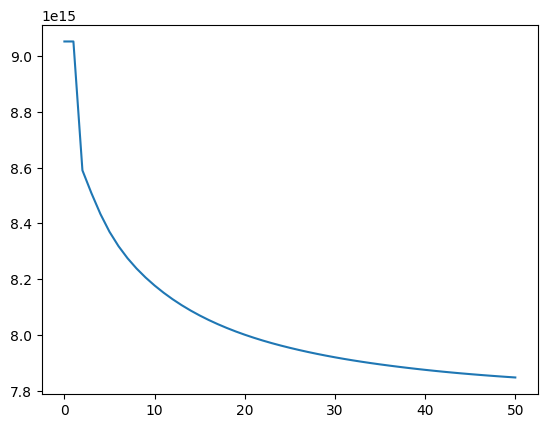

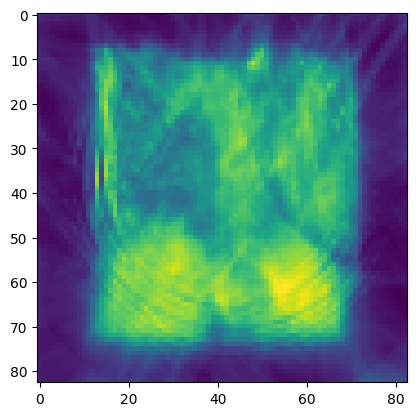

In [7]:
plt.plot(convergence_curve)
plt.show()
plt.imshow(np.sum(x_RBF[:,:,0], axis = -1))


Set up the reconstruction model

In [8]:
odf_RBF = odfs.GaussianRBF(grid, point_groups.octahedral, kernel_sigma)

+ **mask_threshold**: Pick a threshold value to determine what pixels to plot. <br />
This value should sit in between the two bumps

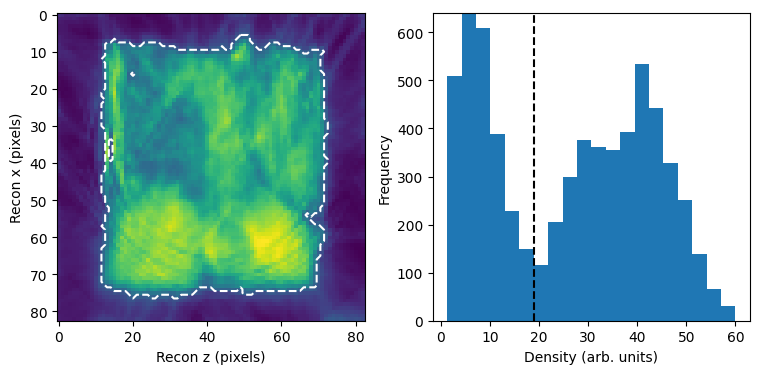

In [9]:
mask_threshold = 19

plt.figure(figsize = (9, 4))
dens = np.sum(x_RBF, axis = -1)
mask = dens > mask_threshold

plt.subplot(1,2,1)
plt.imshow(dens)
plt.contour(mask[:,:,0], levels = [0.5], colors=[(1,1,1)],linestyles='dashed')
plt.xlabel('Recon z (pixels)'); plt.ylabel('Recon x (pixels)');

plt.subplot(1,2,2)
freq = plt.hist(dens.flatten(), bins = 20)[0]
plt.ylim(0, np.max(freq[5:])*1.2)
plt.plot([mask_threshold]*2, [0, np.max(freq[5:])*1.2], 'k--')
plt.xlabel('Density (arb. units)')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Some options for defining the plot
IVP_map_direction = np.array([0, 0, 1])
pole_figure_hkl = np.array([0, 0, 1])
coeffs_2d = x_RBF[:,:,0,:]
example_voxel = (40, 40, 0)
stepsize = 0.003
pcolor_opts = {'edgecolors':'face', 'vmin':0, 'rasterized':True}
imshow_opts = {'extent':(0,coeffs_2d.shape[1]*stepsize,coeffs_2d.shape[0]*stepsize,0)}

def tomogram_set_axes(ax):
    ax.set_xlabel('z (mm)')
    ax.set_ylabel('x (mm)')
    ax.grid()

# Compute the plotted quantities
mask_2d = np.sum(coeffs_2d, axis = -1) > mask_threshold

# Compute max direction IVP colormap
max_orientation_index = np.argmax(coeffs_2d, axis = -1)
max_orientation_index[~mask_2d] = -1
IVP_map_direction_normed = IVP_map_direction / np.linalg.norm(IVP_map_direction)
grid_ivp_directions = odf_RBF.grid.inv().apply(IVP_map_direction_normed)
max_orientation = grid_ivp_directions[max_orientation_index]
ivp_map_rgb = odftt.plot_tools.IPF_color(max_orientation, 'cubic')
ivp_map_rgb[~mask_2d] = 1 # (1 if you want white background, 0 if you want black background )

# Compute approximate texture index
J = np.sqrt(np.var(coeffs_2d, axis = -1)) / np.mean(coeffs_2d, axis = -1)
J[~mask_2d] = np.nan

# Compute a pole-figure of a single voxel
voxel_coeffs = x_RBF[example_voxel[0], example_voxel[1], example_voxel[2],:]
polefigure, theta_grid, phi_grid = odf_RBF.make_polefigure_map(voxel_coeffs, B @ pole_figure_hkl)

/tmp/ipykernel_3743071/1284929058.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3743071/1284929058.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


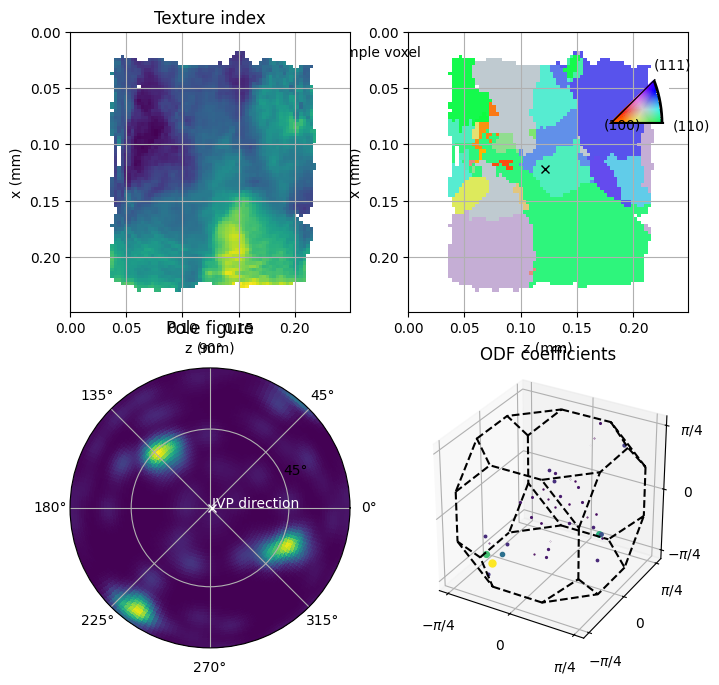

In [11]:
# Build the plot
fig = plt.figure(figsize = (8, 8))

# PLot IVP-map
ax = plt.subplot(2,2,2)
ax.imshow(ivp_map_rgb, **imshow_opts)
ax.plot((example_voxel[1]+0.5)*stepsize, (example_voxel[0]+0.5)*stepsize, 'kx')
ax.text((example_voxel[1]+0.5)*stepsize - 0.2, (example_voxel[0]+0.5)*stepsize - 0.1, 'example voxel', color = 'k')
tomogram_set_axes(ax)
ax = fig.add_subplot([0.8, 0.75, 0.10, 0.10], polar = True)
odftt.plot_tools.make_color_legend(ax, 'cubic')

# Plot texture index
ax = plt.subplot(2,2,1)
img = ax.imshow(J, **imshow_opts)
tomogram_set_axes(ax)
ax.set_title('Texture index')

# PLot pole figure
ax = plt.subplot(2,2,3, polar=True)
img = ax.pcolormesh(phi_grid, np.arctan(theta_grid/2), polefigure, **pcolor_opts)
ax.set_yticks([np.arctan(ii*np.pi/8) for ii in range(1,2)])
ax.set_yticklabels(['45°'])
ax.yaxis.label.set_color('w')
ax.set_title('Pole figure')
if IVP_map_direction_normed[2] < 0.0:
    IVP_map_direction_normed = -IVP_map_direction_normed
IVP_map_theta = np.arccos(IVP_map_direction_normed[2])
IVP_map_phi = np.arctan2(IVP_map_direction_normed[1], IVP_map_direction_normed[0])
ax.plot(IVP_map_phi, np.arctan(IVP_map_theta/2), 'wx')
ax.text(IVP_map_phi+0.3, np.arctan(IVP_map_theta/2), 'IVP direction',color = 'w')

# PLot ODF modes in Rodriguez-vector representation
ax = plt.subplot(2,2,4, projection='3d')
odftt.plot_tools.plot_orientation_coeffs(voxel_coeffs, odf_RBF.grid, ax, point_group_string='cubic')
ax.set_title('ODF coefficients')
fig.tight_layout()
fig.show()


/!!!\ BEFORE LAUNCHING THE JOBS /!!!\
* Edit the batch_scripts/schedule_slice.slurm file
* eventually replace the conda activation command :
`source /cvmfs/hpc.esrf.fr/software/packages/linux/x86_64/jupyter-slurm/2025.04.3/etc/profile.d/conda.sh`
* Replace the path to activate the mumott environnement on your current session
`conda init
conda activate /home/esrf/username/.conda/envs/mumott_env`


In [12]:
cur_wd = os.getcwd()
maxiter = 50

for z_slice_index in range(0, 3):
    os.system(f"sbatch batch_scripts/schedule_slice.slurm {z_slice_index} {maxiter} {sample} {cur_wd}")


Submitted batch job 27275824
Submitted batch job 27275825
Submitted batch job 27275826
